$
Importing\;Neccessary\;libraries.
$

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random 
import gym
from gym import wrappers
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import time
from copy import deepcopy
from math import *
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GaussianNoise,Concatenate
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from collections import deque

$$
\textbf{Problem1: Deep Deterministic Policy Gradients
}
$$

$$
(a)\;Developing\;corresponding\;gym\;environments
$$

$$
Playing\;Mountain\;car\;using\;Random\;agent
$$

In [4]:
MC_env = gym.make('MountainCarContinuous-v0')
for i in range(10):
    observation= MC_env.reset()
    for t in range(100):
        action = MC_env.action_space.sample()
        observation, reward, done, info = MC_env.step(action)
    print('Reward received in %d th episode is %d'%(i+1,reward))
MC_env.close()

Reward received in 1 th episode is 0
Reward received in 2 th episode is 0
Reward received in 3 th episode is 0
Reward received in 4 th episode is 0
Reward received in 5 th episode is 0
Reward received in 6 th episode is 0
Reward received in 7 th episode is 0
Reward received in 8 th episode is 0
Reward received in 9 th episode is 0
Reward received in 10 th episode is 0


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


$$
Playing\;Lunar\;Lander\;using\;random\;agent
$$

In [3]:
LL_env = gym.make('LunarLanderContinuous-v2')
for i in range(10):
    observation= LL_env.reset()
    for t in range(100):
        action = LL_env.action_space.sample()
        observation, reward, done, info = LL_env.step(action)
    print('Reward received in %d th episode is %d'%(i+1,reward))
LL_env.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Reward received in 1 th episode is 1
Reward received in 2 th episode is 0
Reward received in 3 th episode is -3
Reward received in 4 th episode is -2
Reward received in 5 th episode is 7
Reward received in 6 th episode is -4
Reward received in 7 th episode is -100
Reward received in 8 th episode is -100
Reward received in 9 th episode is -3
Reward received in 10 th episode is -18


$
Actor\;Network
$

In [0]:
class Actor:

    def __init__(self, state_space,size_of_action,lr=0.0001):
        state_input = Input(shape=state_space)
        i = Dense(48, activation='elu', use_bias=True, kernel_initializer='he_uniform')(state_input)
        i = Dense(48, activation='elu', use_bias=True, kernel_initializer='he_uniform')(i)
        i = Dense(24, activation='elu', use_bias=True, kernel_initializer='he_uniform')(i)
        
        out = Dense(size_of_action, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform')(i)

        self.model = Model(inputs=state_input, outputs=out)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.model.compile(optimizer=self.optimizer, loss='mse')


    def train(self, X_train, critic_grads):
        with tf.GradientTape() as tape:
            y_pred = self.model(X_train, training=True)
        actor_grads = tape.gradient(y_pred, self.model.trainable_variables, output_gradients=-critic_grads)
        self.optimizer.apply_gradients(zip(actor_grads, self.model.trainable_variables))


$
Critic\;Network
$

In [0]:
class Critic:

    def __init__(self, state_shape, action_shape,size_of_action, lr=0.001):
        state_input = Input(shape=state_shape)
        state_h1 = Dense(48, activation='elu', use_bias=True, kernel_initializer='he_uniform')(state_input)

        action_input = Input(shape=action_shape)

        merged = Concatenate()([state_h1, action_input])
        merged_h1 = Dense(48, activation='relu', use_bias=True, kernel_initializer='he_uniform')(merged)
        merged_h2 = Dense(24, activation='relu', use_bias=True, kernel_initializer='he_uniform')(merged_h1)

        output = Dense(size_of_action, activation='linear', use_bias=True, kernel_initializer='he_uniform')(merged_h2)

        self.model = Model(inputs=[state_input, action_input], outputs=output)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.model.compile(optimizer=self.optimizer, loss='mse')
                

$
Replay\;Buffer\;Function
$

In [0]:
class ReplayBuffer:

    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)    

    def add(self, item):
        self.buffer.append(item)   

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)

        item_count = len(batch[0])
        res = []
        for i in range(item_count):
            k = np.array([item[i] for item in batch])
            if len(k.shape)==1: k = k.reshape(k.shape+(1,))
            res.append(k)
        return res 

    def __len__(self):
        return len(self.buffer)

class ReplayBufferItem:
    def __init__(self, state, action, reward, next_state, done):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done

    def __str__(self):
        return "ReplayBufferItem"



$
Ornstein\;Uhlenbeck\;Noise\;function
$

In [0]:
class OrnsteinUhlenbeckProcess(object):
    def __init__(self, theta=0.15, mu=0, sigma=1, x0=0, dt=1e-2, n_steps_annealing=250, size=1):
        self.theta = theta
        self.sigma = sigma
        self.n_steps_annealing = n_steps_annealing
        self.sigma_step = - self.sigma / float(self.n_steps_annealing)
        self.x0 = x0
        self.mu = mu
        self.dt = dt
        self.size = size

    def generate(self, step):
        sigma = max(0, self.sigma_step * step + self.sigma)
        x = self.x0 + self.theta * (self.mu - self.x0) * self.dt + sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x0 = x
        return x

$
Train\;and\;DDPG\;function
$

In [59]:
gamma = 0.95
batch_size = 64
tau = 0.01
lr_A=0.0001
lr_C=0.001

env = gym.make('MountainCarContinuous-v0')

actorNet = Actor(env.observation_space.shape,
                 np.shape(env.action_space.sample())[0],
                 lr_A)

actorNet_target = Actor(env.observation_space.shape,
                        np.shape(env.action_space.sample())[0])

criticNet = Critic(env.observation_space.shape, 
                   env.action_space.shape,
                   np.shape(env.action_space.sample())[0],
                   lr=lr_C)

criticNet_target = Critic(env.observation_space.shape,
                          env.action_space.shape,
                          np.shape(env.action_space.sample())[0])

rpm = ReplayBuffer(1000000)

def replace_weights(tau=tau):
    theta_a,theta_c = actorNet.model.get_weights(),criticNet.model.get_weights()
    theta_a_targ,theta_c_targ = actorNet_target.model.get_weights(),criticNet_target.model.get_weights()

    theta_a_targ = [theta_a[i]*tau + theta_a_targ[i]*(1-tau) for i in range(len(theta_a))]
    theta_c_targ = [theta_c[i]*tau + theta_c_targ[i]*(1-tau) for i in range(len(theta_c))]

    actorNet_target.model.set_weights(theta_a_targ)
    criticNet_target.model.set_weights(theta_c_targ)

def train(verbose=1, batch_size=batch_size, gamma=gamma):
    if (len(rpm) > batch_size):        
        [s1, a1, r, s2, done] = rpm.sample(batch_size)
        a2 = actorNet_target.model.predict(s2)
        q2 = criticNet_target.model.predict([s2, a2])

        q1_target = r + (1-done) * gamma * q2
        criticNet.model.fit([s1, a1], q1_target, batch_size=batch_size, epochs=1, verbose=verbose, shuffle=False)
        with tf.GradientTape() as tape:
            y_pred = actorNet.model(s1)
            q_pred = criticNet.model([s1, y_pred])
        critic_grads = tape.gradient(q_pred, y_pred)
        actorNet.train(s1, critic_grads)
        
        replace_weights()

def DDPG(epsiodes,iterations):
    scoreList = []

    replace_weights(tau=1.)
    for episode in range(epsiodes):
        state = env.reset()
        state = np.reshape(state, (1, env.observation_space.shape[0]))

        noise = OrnsteinUhlenbeckProcess(size=env.action_space.shape)

        score = 0.0
        for step in range(iterations):
            exploration_noise = noise.generate(episode)
            
            action = np.squeeze(actorNet.model(state))
            action = np.clip(action+exploration_noise, -1.0, 1.0)
            
            newState, reward, done, info = env.step(action) 
            newState = np.reshape(newState, (1, env.observation_space.shape[0]))
            score += reward

            rpm.add((np.squeeze(state), action, reward, np.squeeze(newState), done))
            state = newState

            if done: 
                break

            verbose = 1 if step == 1 else 0    
            train(verbose)

        print('Episode %d'%(episode+1))
        print("Score %f"%(score))
        scoreList.append(score)

    plt.xlabel('Episodes')
    plt.ylabel('score')
    plt.title("Progress")
    plt.plot(scoreList, label='Score')
    plt.savefig('Result.png')
    plt.show()

    env.close()


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


$
Implementation\;of\;DDPG\;algorithm\;on\;Mountain\;car
$

Episode 1
Score -12.037506
1/1 [==============================] - 0s 1ms/step - loss: 1.3381e-04
Episode 2
Score -8.415787
1/1 [==============================] - 0s 1ms/step - loss: 6.5860e-05
Episode 3
Score -7.643631
1/1 [==============================] - 0s 1ms/step - loss: 3.1837e-05
Episode 4
Score 94.213121
1/1 [==============================] - 0s 1ms/step - loss: 157.0807
Episode 5
Score -6.108890
1/1 [==============================] - 0s 1ms/step - loss: 0.1803
Episode 6
Score -12.931328
1/1 [==============================] - 0s 1ms/step - loss: 0.0255
Episode 7
Score -15.618125
1/1 [==============================] - 0s 1ms/step - loss: 0.0020
Episode 8
Score -1.704768
1/1 [==============================] - 0s 1ms/step - loss: 0.5863
Episode 9
Score -17.648858
1/1 [==============================] - 0s 1ms/step - loss: 0.1244
Episode 10
Score -12.704721
1/1 [==============================] - 0s 1ms/step - loss: 0.0019
Episode 11
Score -2.383753
1/1 [============================

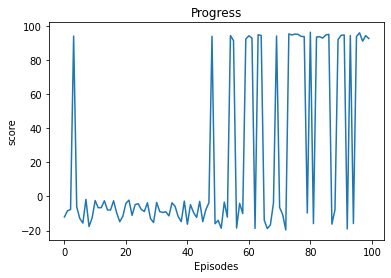

In [10]:
DDPG(epsiodes=100,
     iterations=200)

$
Results\;of\;Mountain\;car\;continous\;DDPG:\\
\rightarrow Above\;plot\;is\;the\;training\;progress\;for\;100\;epochs.\\
\rightarrow This\;is\;the\;plot\;of\;training\;progress\;for\;which\;I\;trained\;for\;500\;epochs.\\
$

![](https://drive.google.com/uc?id=1nJF7lSBjjFrej1S52Nfc9LQtwwotyqaG)


$
Defining\;Actor\;and\;critic\;network\;for\;lunar\;lander\;Continuous
$

In [0]:
gamma = 0.90
batch_size = 64
tau = 0.01
lr_A=0.001
lr_C=0.005
env = gym.make('LunarLanderContinuous-v2')

actorNet = Actor(env.observation_space.shape,
                 np.shape(env.action_space.sample())[0],
                 lr_A)

actorNet_target = Actor(env.observation_space.shape,
                        np.shape(env.action_space.sample())[0])

criticNet = Critic(env.observation_space.shape, 
                   env.action_space.shape,
                   np.shape(env.action_space.sample())[0],
                   lr=lr_C)

criticNet_target = Critic(env.observation_space.shape,
                          env.action_space.shape,
                          np.shape(env.action_space.sample())[0])

rpm = ReplayBuffer(1000000)

$
Implementation\;of\;DDPG\;algorithm\;on\;Lunar\;lander\;Continuous
$

Episode 1
Score -149.722415
Episode 2
Score -646.890978
1/1 [==============================] - 0s 1ms/step - loss: 10.5471
Episode 3
Score -146.320036
1/1 [==============================] - 0s 1ms/step - loss: 220.6983
Episode 4
Score -512.769239
1/1 [==============================] - 0s 1ms/step - loss: 6.4999
Episode 5
Score -429.694074
1/1 [==============================] - 0s 1ms/step - loss: 114.3228
Episode 6
Score -767.703465
1/1 [==============================] - 0s 2ms/step - loss: 22.9544
Episode 7
Score -401.895712
1/1 [==============================] - 0s 1ms/step - loss: 3.9652
Episode 8
Score -520.368661
1/1 [==============================] - 0s 1ms/step - loss: 96.6633
Episode 9
Score -153.856125
1/1 [==============================] - 0s 1ms/step - loss: 4.3897
Episode 10
Score -293.713228
1/1 [==============================] - 0s 1ms/step - loss: 5.3244
Episode 11
Score -526.880556
1/1 [==============================] - 0s 1ms/step - loss: 44.9940
Episode 12
Score -659.

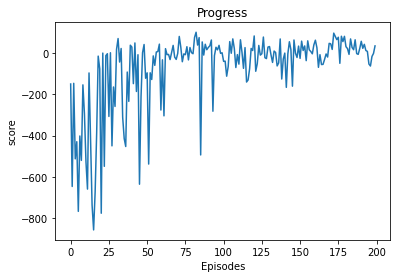

In [15]:
DDPG(epsiodes=200,
     iterations=200)

$
Results\;of\;Lunar\;Lander\;continous\;DDPG:\\
\rightarrow Above\;plot\;is\;the\;training\;progress\;for\;200\;epochs.\\
\rightarrow This\;is\;the\;plot\;of\;training\;progress\;for\;which\;I\;trained\;for\;500\;epochs.\\
$

![](https://drive.google.com/uc?id=1G_LGK8bn9WwEgknCuVy1va8Wc6XbkWSB)


$
\textbf{(c)Ornstein Ulhenbeck (OU) noise for exploration.}
$

$
Training\;DDPG\;without\;OU\;noise.
$

In [39]:
gamma = 0.95
batch_size = 64
tau = 0.01
lr_A=0.0001
lr_C=0.001

env = gym.make('MountainCarContinuous-v0')

actorNet = Actor(env.observation_space.shape,
                 np.shape(env.action_space.sample())[0],
                 lr_A)

actorNet_target = Actor(env.observation_space.shape,
                        np.shape(env.action_space.sample())[0])

criticNet = Critic(env.observation_space.shape, 
                   env.action_space.shape,
                   np.shape(env.action_space.sample())[0],
                   lr=lr_C)

criticNet_target = Critic(env.observation_space.shape,
                          env.action_space.shape,
                          np.shape(env.action_space.sample())[0])

rpm = ReplayBuffer(1000000)

def DDPG_no_noise(epsiodes,iterations):
    scoreList = []

    replace_weights(tau=1.)
    for episode in range(epsiodes):
        state = env.reset()
        state = np.reshape(state, (1, env.observation_space.shape[0]))


        score = 0.0
        for step in range(iterations):
            
            action = np.squeeze(actorNet.model(state))
            action = np.clip(action, -1.0, 1.0)

            action_list=list()
            action_list.append(action)
            newState, reward, done, info = env.step(action_list)
            newState = np.reshape(newState, (1, env.observation_space.shape[0]))
            score += reward

            rpm.add((np.squeeze(state), action, reward, np.squeeze(newState), done))
            state = newState

            if done: 
                break

            verbose = 1 if step == 1 else 0    
            train(verbose)

        print('Episode %d'%(episode+1))
        print("Score %f"%(score))
        scoreList.append(score)

    plt.xlabel('Episodes')
    plt.ylabel('score')
    plt.title("Progress")
    plt.plot(scoreList, label='Score')
    plt.savefig('Result.png')
    plt.show()

    env.close()


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 1
Score -6.006478
1/1 [==============================] - 0s 1ms/step - loss: 5.9687e-05
Episode 2
Score -1.232871
1/1 [==============================] - 0s 1ms/step - loss: 1.9291e-05
Episode 3
Score -0.284346
1/1 [==============================] - 0s 1ms/step - loss: 7.5038e-06
Episode 4
Score -0.401560
1/1 [==============================] - 0s 1ms/step - loss: 2.7265e-06
Episode 5
Score -0.319352
1/1 [==============================] - 0s 1ms/step - loss: 1.1026e-06
Episode 6
Score -0.050473
1/1 [==============================] - 0s 1ms/step - loss: 1.0438e-06
Episode 7
Score -0.019979
1/1 [==============================] - 0s 1ms/step - loss: 2.9479e-07
Episode 8
Score -0.031979
1/1 [==============================] - 0s 1ms/step - loss: 3.5224e-07
Episode 9
Score -0.021775
1/1 [==============================] - 0s 1ms/step - loss: 9.2703e-07
Episode 10
Score -0.012991
1/1 [==============================] - 0s 1ms/step - loss: 4.0595e-07
Episode 11
Score -0.002579
1/1 [=======

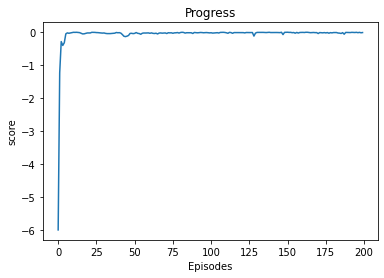

In [40]:
DDPG_no_noise(epsiodes=200,
              iterations=200)

$
\rightarrow We\;can\;clearly\;see\;DDPG\;converged\;at\;Score=0\;if\;it\;is\;trained\;without\;guassian\;noise.\\
\rightarrow We\;can\;observe\;from\;Mountain-car\;progress\;plot\;in\;(b)\;DDPG\;with\;noise\;converged\;at\;Score=93-94.
\implies We\;can\;clearly\;say\;that\;guassian\;noise\;helps\;a\;lot\;in\;exploration.\\
\implies Without\;noise\;we\;are\;just\;exploiting\;the\;environment\;without\;exploring.
$
$$
\blacksquare
$$

$$
\textbf{Problem2: Bandit
Algorithms
}
$$

$
(a)Developing\;Bandit\;environment
$

In [0]:
class bandit_env:
    def __init__(self, k, eps, iters, mu,decay,ucb):
        self.k = k
        self.eps = eps
        self.c=1
        self.iters = iters
        self.ucb=ucb
        if self.ucb==False:
          self.n = 0
          self.n_k = np.zeros(k)
        else:
          self.n = 1
          self.n_k = np.ones(k)
        self.mean_reward = 0
        self.avg_regret=0
        self.reward = np.zeros(iters)
        self.regret = np.zeros(iters)
        self.k_reward = np.zeros(k)
        self.decay=decay
        self.max_array=np.zeros(k)
        self.no_arm_pulled = np.zeros(k)
        self.random_rewards = np.random.normal(mu, 1, k)
        
    def pullarm(self):
        p = np.random.rand()
        if self.ucb==False:
          if self.n == 0:
              a = np.random.choice(self.k)
          if self.decay==True:
            if p < 1/(1+self.n/self.k):
                a = np.random.choice(self.k)
            else:
              a =np.argmax(self.k_reward)
          else:
            if p < self.eps:
                a = np.random.choice(self.k)
            else:
                a = np.argmax(self.k_reward)
        else:
          a = np.argmax(self.k_reward+self.c*np.sqrt(np.log(self.n)/self.n_k))
          
        reward = np.random.normal(self.random_rewards[a], 1)
        
        self.n += 1
        self.n_k[a] += 1
        
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.n_k[a]
        
    def average_reward(self):
        for i in range(self.iters):
            self.pullarm()
            self.reward[i] = self.mean_reward
            self.max_array.fill(np.amax(self.k_reward))

            self.avg_regret=np.sum(self.max_array-self.k_reward)

            self.regret[i] = self.avg_regret

            


$
Function\;for\;calculating\;average\;reward\;of\;Multi\;arm\;bandit.
$

In [0]:
def MAB(k,N,show,epsilon,decay,ucb):
  rewards = np.zeros(N)

  for i in range(N):
      karm = bandit_env(k, epsilon, N,mu=0,decay=decay,ucb=ucb)
      karm.average_reward()
      
      rewards = rewards + (
          karm.reward - rewards) / (i + 1)
  
  if ucb==True:
    label="ucb"
  else:
    if decay==True:
      label="$\epsilon-greedy$"+" with decay"
    else:
      label="$\epsilon=$"+str(epsilon)
  plt.plot(rewards, label=label)
  plt.xlabel("N="+str(N))
  plt.ylabel("Average Reward")
  plt.title("Average Rewards after " + str(N) + " Episodes")
  if show==True:
    plt.legend()
    plt.show()

$
(b)Solving\;Multi-arm\;bandit\;with\;greedy\;approach(\epsilon=0)
$

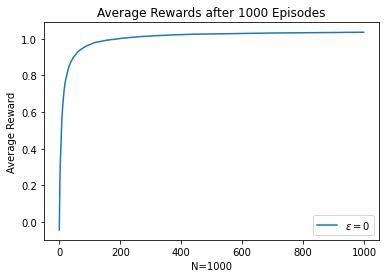

In [10]:
MAB(k=10,
    N=1000,
    epsilon=0,
    show=True,
    decay=False,
    ucb=False)

$
(b)Solving\;Multi-arm\;bandit\;with\;greedy\;approach(\epsilon=0.01)
$

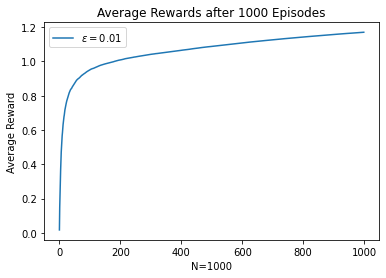

In [0]:
MAB(k=10,
    N=1000,
    epsilon=0.01,
    show=True,
    decay=False,
    ucb=False)

$
(b)Solving\;Multi-arm\;bandit\;with\;greedy\;approach(\epsilon=0.1)
$

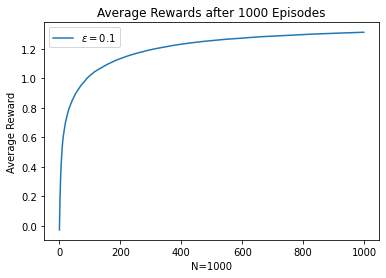

In [0]:
MAB(k=10,
    N=1000,
    epsilon=0.1,
    show=True,
    decay=False,
    ucb=False)

$
(b)Solving\;Multi-arm\;bandit\;with\;greedy\;with\;decay.
$

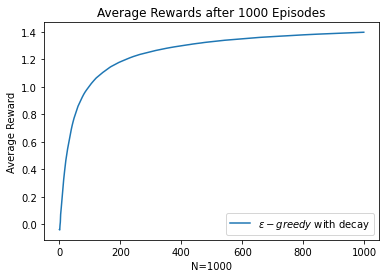

In [0]:
MAB(k=10,
    N=1000,
    epsilon=0.1,
    show=True,
    decay=True,
    ucb=False)

$
(b)Solving\;Multi-arm\;bandit\;using\;UCB\;algorithm.
$

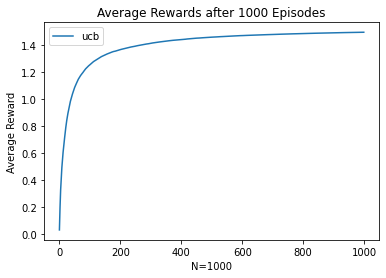

In [0]:
MAB(k=10,
    N=1000,
    epsilon=0.1,
    show=True,
    decay=False,
    ucb=True)

$
\textbf{(c)Plot of average reward obtained using each of the above strategies (in same graph)}.
$

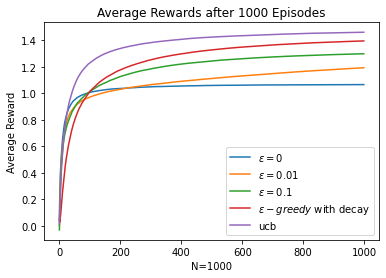

In [0]:
MAB(k=10,
    N=1000,
    epsilon=0,
    show=False,
    decay=False,
    ucb=False)
MAB(k=10,
    N=1000,
    epsilon=0.01,
    show=False,
    decay=False,
    ucb=False)
MAB(k=10,
    N=1000,
    epsilon=0.1,
    show=False,
    decay=False,
    ucb=False)
MAB(k=10,
    N=1000,
    epsilon=0.1,
    show=False,
    decay=True,
    ucb=False)
MAB(k=10,
    N=1000,
    epsilon=0.1,
    show=True,
    decay=False,
    ucb=True)



$
Function\;for\;ploting\;histogram\;of\;average\;number\;of\;times\;an\;arm\;is\;pulled
$

In [0]:
def MAB_hist(k,N,show,epsilon,decay,ucb,num):
  rewards = np.zeros(N)
  no_arm_pulled = np.zeros(k)

  for i in range(N):
      karm = bandit_env(k, epsilon, N,mu=0,decay=decay,ucb=ucb)
      karm.average_reward()

      no_arm_pulled = no_arm_pulled + (
        karm.n_k - no_arm_pulled)/(i + 1)
  
  if ucb==True:
    label="ucb"
  else:
    if decay==True:
      label="$\epsilon=$"+"with decay"
    else:
      label="$\epsilon=$"+str(epsilon)
  bins = np.linspace(0, k-1, k)

  plt.bar(bins+num, no_arm_pulled, 
          width = 0.2, 
          label=label)
  plt.xlim([0,k])
  plt.title("Arm pulled by each algorithm")
  plt.xlabel("Arm pulled")
  plt.ylabel("Average number of times arm pulled")
  if show==True:
    plt.legend()
    plt.show()

$
\textbf{(d)Plot of a histogram consisting of average number of times each of the 10 arms is pulled for each of the algorithm}
$

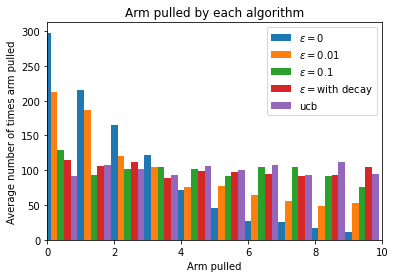

In [0]:
MAB_hist(k=10,
    N=1000,
    epsilon=0,
    show=False,
    decay=False,
    ucb=False,
    num=0)
MAB_hist(k=10,
    N=1000,
    epsilon=0.01,
    show=False,
    decay=False,
    ucb=False,
    num=0.2)
MAB_hist(k=10,
    N=1000,
    epsilon=0.1,
    show=False,
    decay=False,
    ucb=False,
    num=0.4)
MAB_hist(k=10,
    N=1000,
    epsilon=0.1,
    show=False,
    decay=True,
    ucb=False,
    num=0.6)
MAB_hist(k=10,
    N=1000,
    epsilon=0.1,
    show=True,
    decay=False,
    ucb=True,
    num=0.8)



$
Function\;for\;calculating\;average\;regret\;of\;each\;algorithm.
$

In [0]:
def MAB_regret(k,N,show,epsilon,decay,ucb):
  regrets=np.zeros(N)

  for i in range(N):
      karm = bandit_env(k, epsilon, N,mu=0,decay=decay,ucb=ucb)
      karm.average_reward()
      
      regrets = regrets + (
          karm.regret - regrets) / (i + 1)
  
  if ucb==True:
    label="$\epsilon=$"+str(0)
  else:
    if decay==True:
      label="$\epsilon-greedy$"+" with decay"
    else:
      if epsilon==0:
        label="ucb"
      else:
        label="$\epsilon=$"+str(epsilon)
  plt.plot(regrets, label=label)
  plt.xlabel("N="+str(N))
  plt.ylabel("Average Regret")
  plt.title("Average Regrets after " + str(N) + " Episodes")
  if show==True:
    plt.legend()
    plt.show()

$
\textbf{(e)Plot the average regret as a function of time for each algorithm.}
$

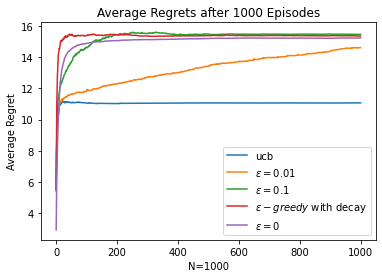

In [15]:
MAB_regret(k=10,
    N=1000,
    epsilon=0,
    show=False,
    decay=False,
    ucb=False)
MAB_regret(k=10,
    N=1000,
    epsilon=0.01,
    show=False,
    decay=False,
    ucb=False)
MAB_regret(k=10,
    N=1000,
    epsilon=0.1,
    show=False,
    decay=False,
    ucb=False)
MAB_regret(k=10,
    N=1000,
    epsilon=0.1,
    show=False,
    decay=True,
    ucb=False)
MAB_regret(k=10,
    N=1000,
    epsilon=0.1,
    show=True,
    decay=False,
    ucb=True)




$
\textbf{(f)Which of the above bandit algorithm is better}
$

$
\implies From\;above\;plots\;we\;can\;easily\;observe\;that\;the\;average\;reward\;of\;ucb\;is\;way\;higher\;than\;others\;and\;average\;regret\;of\;ucb\;is\;lower\;than\;others.So\;UCB\;is\;the\;best\;algorithm\;for\;solving\;multi\;arm\;bandit\;among\;the\;given\;five\;algorithms\\
\implies The\;order\;of\;better\;algorithms\;from\;above\;plots\;are:ucb>\epsilon\;with\;decay>\epsilon=0.1>\epsilon=0.01>\epsilon=0.
$

$
\textbf{(g)Mean rewards of the second best arm and the best arm are close.}
$
$
\rightarrow If\;the\;gap\;between\;sceond\;best\;arm\;and\;the\;best\;arm\;is\;close\;and\;if\;we\;are\;following\;an\;approach\; that\;does\;not\;do\;enough\;exploration\;and\;ends\; exploiting\;a\;suboptimal\;arm. 
$
$
\rightarrow In\;greedy\;approach\;there\;is\;no\;exploration\;strategy.The\;problem\;\;in\;greedy\;approach \;only\;exploits,\;as\;it\;always\;picks\;the\;same\;action \;without\;worrying\;about\;exploring\;other\;actions\;that\; might\;return\;a\;better\;reward. Some\;exploration\;is \;necessary\;to\;actually\;find\;an\;optimal\;arm,\;otherwise \;we\;might\;end\;up\;pulling\;a\;suboptimal\;arm\;forever.
$
$
\rightarrow Same\;with\;epsilon\;greedy\;approaches\;it\;explores\;with\;a\;probaility\;of\;\epsilon.
$
$
\rightarrow In\;UCB\;we\;exploit\;and\;explore\;at\;same\;time.
$
![](https://drive.google.com/uc?id=1iYrLOt6nLAPZ9dYJ528mV9mGXInm1PZT)
$
\rightarrow In\;Rewards\;plot\;in(c)\;we\;can\;observe\;greedy\;and\;epsilon\;greedy\;strategies\;got\;stuck\;at\;suboptimal\;arm.
$
$$
\blacksquare
$$

$$
\textbf{Problem3: Monte Carlo Tree Search}
$$

$
Creating\;tree\;for\;MCTS
$

In [0]:
class Node:
    def __init__(self, move=None, parent=None, state=None):
        self.move = move  
        self.parentNode = parent 
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.Validmoves()  
        self.playerJustMoved = state.playerJustMoved  

    def UCBSelectChild(self):
        s = sorted(self.childNodes, key=lambda c: c.wins / c.visits + sqrt(2*log(self.visits) / c.visits))[-1]
        return s

    def AddChild(self, m, s):
        n = Node(move=m, parent=self, state=s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n

    def Update(self, result):
        self.visits += 1
        self.wins += result



$
Creating\;Tic\;tac\;toe\;environment.
$

In [0]:
class Tic_tac_toe:
    def __init__(self):
        self.playerJustMoved = 2
        self.ended = False
        self.board = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    def Clone(self):
        return deepcopy(self)
    
    def print(self):
      print(np.array(self.board))

    def DoMove(self, move):
        winning_pairs = [[[1, 2], [4, 8], [3, 6]], 
                         [[0, 2], [4, 7]], 
                         [[0, 1], [4, 6], [5, 8]], 
                         [[0, 6], [4, 5]],  
                         [[0, 8], [1, 7], [2, 6], [3, 5]], 
                         [[2, 8], [3, 4]], 
                         [[0, 3], [4, 2], [7, 8]],
                         [[6, 8], [1, 4]], 
                         [[6, 7], [0, 4], [2, 5]],
                         ]

        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved

        for index1, index2 in winning_pairs[move]:
            if self.playerJustMoved == self.board[index1] == self.board[index2]:
                self.ended = True

    def Validmoves(self):
      if self.ended:
        return []
      else:
        valid_moves=list()
        for i in range(9):
          if self.board[i]==0:
            valid_moves.append(i)
        return valid_moves 

    def GetResult(self, player):
        for (x, y, z) in [(0, 1, 2), (3, 4, 5), (6, 7, 8), (0, 3, 6), (1, 4, 7),
                          (2, 5, 8), (0, 4, 8), (2, 4, 6)]:
            if self.board[x] == self.board[y] == self.board[z]:
                if self.board[x] == player:
                    return 1
                elif self.board[x] != 0:
                    return 0

        if self.Validmoves() == []:
            return 0.5


$
Selection,Expansion\;and\;Backpropagate\;functions.
$

In [0]:
def Selection(node,state):
    while node.untriedMoves == [] and node.childNodes != []: 
        node = node.UCBSelectChild()
        state.DoMove(node.move)
    return (node,state)

def Expansion(node,state):
    if node.untriedMoves != []: 
        m = random.choice(node.untriedMoves)
        state.DoMove(m)
        node = node.AddChild(m, state)  


    while state.Validmoves() != []:  
        state.DoMove(random.choice(state.Validmoves()))
    
    return (node,state)

def Back_propagate(node,state):
    while node != None:  
      node.Update(state.GetResult(node.playerJustMoved))  
      node = node.parentNode

    return (node,state)


In [0]:
def UCB(rootstate, iterations,player):

    rootnode = Node(state=rootstate)

    for i in range(iterations):
        node = rootnode
        if player=='safe':
          state=rootstate
        else:
          state = rootstate.Clone()

        (node,state)=Selection(node,state)
        
        (node,state)=Expansion(node,state)

        (node,state)=Back_propagate(node,state)

    return sorted(rootnode.childNodes, key=lambda c: c.visits)[-1].move


def Random_agent(state):
    return random.choice(state.Validmoves())

def Safe_agent(state):
  winning_pairs = [[[1, 2], [4, 8], [3, 6]], 
                         [[0, 2], [4, 7]],  
                         [[0, 1], [4, 6], [5, 8]], 
                         [[0, 6], [4, 5]], 
                         [[0, 8], [1, 7], [2, 6], [3, 5]], 
                         [[2, 8], [3, 4]], 
                         [[0, 3], [4, 2], [7, 8]], 
                         [[6, 8], [1, 4]], 
                         [[6, 7], [0, 4], [2, 5]], 
                         ]

  valid_moves=state.Validmoves()
  for move in valid_moves:
    for index1, index2 in winning_pairs[move]:
      if state.playerJustMoved == state.board[index1] == state.board[index2]:
        state.ended = True
        return move
        
  return random.choice(state.Validmoves())

def check_loss(state):
  winning_pairs = [[[1, 2], [4, 8], [3, 6]], 
                      [[0, 2], [4, 7]],  
                      [[0, 1], [4, 6], [5, 8]], 
                      [[0, 6], [4, 5]], 
                      [[0, 8], [1, 7], [2, 6], [3, 5]], 
                      [[2, 8], [3, 4]], 
                      [[0, 3], [4, 2], [7, 8]], 
                      [[6, 8], [1, 4]], 
                      [[6, 7], [0, 4], [2, 5]], 
                      ]

  valid_moves=state.Validmoves()
  for move in valid_moves:
    for index1, index2 in winning_pairs[move]:
      if state.playerJustMoved == state.board[index1] == state.board[index2]:
        return True
  return False


$
\textbf{(a)A Tic-Tac-Toe agent using the MCTS algorithm.}
$

In [0]:
def MCTS(simulations,no_of_games,player):
    won = 0
    lost = 0
    draw = 0
    for i in range(no_of_games):
        state = Tic_tac_toe()
        toss=random.randint(0,1) 
        if toss==1:
              state.playerJustMoved == 1
        else:
              state.playerJustMoved == 2

        while (state.Validmoves() != []):
            if state.playerJustMoved == 1:
                m = UCB(rootstate=state, iterations=simulations,player=player)
            else:
                if player=='random':
                  m=Random_agent(state)
                elif player=='itself':
                  m = UCB(rootstate=state, iterations=simulations,player=player)
                else:
                  m = Safe_agent(state)
            state.DoMove(m)
        if state.GetResult(1) == 1:
            lost += 1
        elif state.GetResult(1) == 0:
            won += 1
        else:
            draw += 1

    print("No of wins against "+str(player) +" player: "+str(won))
    print("No of draws against "+str(player) +" player: "+str(draw))
    print("No of defeats against "+str(player) +" player: "+str(lost))

$
\textbf{(b)Test the efficacy of the MCTS agent by soliciting move recommendations.}
$

In [0]:
def MCTS_efficacy(simulations,no_of_games,player,situation):
    won=0
    draw=0
    lost=0
    for i in range(no_of_games):
        state = Tic_tac_toe()
        step=0
        toss=random.randint(0,1) 
        if situation=='middle':
              state.playerJustMoved == 2
        else:
              state.playerJustMoved == 1

        while (state.Validmoves() != []):
            if state.playerJustMoved == 1:
                m = UCB(rootstate=state, iterations=simulations,player=player)
                step+=1
            else:
                if player=='random':
                  if situation=='middle':
                    if step==0:
                      m=5
                      step+=1
                    else :
                      m=Random_agent(state)
                  else:
                    m=Random_agent(state)

                elif player=='itself':
                  m = UCB(rootstate=state, iterations=simulations,player=player)
                else:
                  m = Safe_agent(state)
            state.DoMove(m)
        if state.GetResult(1) == 1:
            lost += 1
        elif state.GetResult(1) == 0:
            won += 1
        else:
            draw += 1

    print("No of wins against "+str(player) +" player: "+str(won))
    print("No of draws against "+str(player) +" player: "+str(draw))
    print("No of defeats against "+str(player) +" player: "+str(lost))

$
Efficacy\;of\;MCTS\;when\;a\;random\;opponent\;occupied\;middle\;of\;the\;board\;in\;first\;step.
$

In [57]:
MCTS_efficacy(simulations=100,
              no_of_games=1000,
              player='random',
              situation='middle')

No of wins against random player: 927
No of draws against random player: 53
No of defeats against random player: 20


$
\textbf{(c)The number of wins,loss and draws by letting the MCTS agent play 1000 games against random agent.} 
$

In [7]:
MCTS(simulations=100,
     no_of_games=1000,
     player='random')

No of wins against random player: 869
No of draws against random player: 93
No of defeats against random player: 38


$
\textbf{(c)The number of wins,loss and draws by letting the MCTS agent play 1000 games against safe agent. }
$

In [8]:
MCTS(simulations=100,
     no_of_games=1000,
     player='safe')

No of wins against safe player: 285
No of draws against safe player: 58
No of defeats against safe player: 657


$
\textbf{(d)The number of wins,loss and draws by letting the MCTS agent play 1000 games against itself.} 
$

In [9]:
MCTS(simulations=100,
     no_of_games=1000,
     player='itself')

No of wins against itself player: 28
No of draws against itself player: 594
No of defeats against itself player: 378


$$
\blacksquare
$$